<a href="https://colab.research.google.com/github/jmhaussaire/SOAI-Project/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [52]:
%reload_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import os
os.chdir("/gdrive/My Drive/SOAI/")
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import scipy.stats
import numpy as np
import copy 
import itertools
from tqdm import tqdm_notebook



# Get bounding box corners from xml file

In [59]:
all_xml = sorted(glob.glob('outputs_17_02_2020/*.xml',key=os.path.getmtime))

tracks = []
ids = []
pbar = tqdm_notebook(total=len(all_xml))
for f in all_xml:
  pbar.update()
  root = ET.parse(f).getroot()  
  v_ids = root.findall('object/pose')
  xmin = root.findall('object/bndbox/xmin')
  ymin = root.findall('object/bndbox/ymin')
  for v_id,x,y in zip(v_ids,xmin,ymin):
    try:
      track = tracks[ids.index(v_id.text)]
      track['x'].append(float(x.text))
      track['y'].append(float(y.text))
    except ValueError:
      ids.append(v_id.text)
      track = dict({
          'v_id' : v_id.text,
          'x' : [float(x.text)],
          'y' : [float(y.text)]
      })
      tracks.append(track)    
  
    

# Classification


parameters

In [0]:
n_cluster = 3
max_iter = 100


Functions

In [0]:
def dist_point(point,line):
  """
    Computes the distance square between a point and a line
    inputs:
      - point : (x,y)
      - line  : (slope, intercept)      
  """
   
  return (point[1] - line[0]*point[0]-line[1])**2
  

def dist_track(track,line):
  """ Computes the distance between a track and a line"""
  all_x = track['x']
  all_y = track['y']
  dist = 0
  for x,y in zip(all_x,all_y):
    dist += dist_point((x,y),line)    
  return dist


def compute_mean(tracks):
  all_x = []
  all_y = []
  for t in tracks:
    all_x += t['x']
    all_y += t['y']
  slope,intercept,_,_,_ = scipy.stats.linregress(all_x, all_y)  
  return slope,intercept

def initialization(n_cluster,tracks):
  clusters = []
  for c in range(n_cluster):
    clusters.append(dict({'mean':0,'tracks':[]}))
  for t in tracks:
    clusters[int(np.random.random()*3)]['tracks'].append(t)
  for c in clusters:
    slope,intercept = compute_mean(c['tracks'])
    c['mean'] = (slope,intercept)
  return clusters



K-means Algorithm

In [63]:
# Compute a k-mean algorithm to cluster the tracks into lanes
clusters = initialization(n_cluster,tracks)

old_clusters = copy.deepcopy(clusters)
n_iter = 0
while True:
  print(n_iter)
  n_iter+=1
  for c in clusters:
    c['tracks'] = []
  for t in tracks:
    min_dist = -1
    for c in clusters:      
      dist = dist_track(t,c['mean'])
      if dist<min_dist or min_dist<0:
        min_dist = dist
        cluster = c
    cluster['tracks'].append(t)
  for c in clusters:
    slope,intercept = compute_mean(c['tracks'])
    c['mean'] = (slope,intercept)
    
  if clusters == old_clusters:
    break
  else:
    old_clusters = copy.deepcopy(clusters)
  if n_iter > max_iter:
    break
    


0
1
2
3
4
5
6
7
8
9
10
11
12


Determine LOI

In [0]:
def get_intersection(slope1,intercept1,slope2,intercept2):
  x = (intercept2-intercept1)/(slope1-slope2)
  y = intercept1+slope1*x
  return x,y

# get the outter most lanes
# by computing the angle between each pair of clusters
# and picking the highest angle
max_sin = 0
for (c1,c2) in itertools.combinations(clusters,2):
  x,y = get_intersection(
      c1['mean'][0],c1['mean'][1],c2['mean'][0],c2['mean'][1])  
  p2 = (x+1,c2['mean'][0]*(x+1) + c2['mean'][1])
  dist = dist_point(p2,c1['mean'])
  sin_angle = np.sqrt(dist)  
  if sin_angle>max_sin:
    max_sin=sin_angle
    pair = (c1,c2)


(c1,c2) = pair
x0,y0 = get_intersection(
      c1['mean'][0],c1['mean'][1],c2['mean'][0],c2['mean'][1])

# find the point of each cluster the furthest away from the intersection
points = []
dists = []
for c in pair:  
  points.append((0,0))
  dists.append(0)
  for track in c['tracks']:
    for x,y in zip(track['x'],track['y']):
      dist = (x-x0)**2 + (y-y0)**2
      if dist>dists[-1]:        
        points[-1] = (x,y)
        dists[-1] = dist
points = np.array(points)

# Take the shorter of the two distances,
# Pick a point on each lane which is at 90% of that distance
# These two points determine your LOI
margin = 0.9
dist = margin*np.sqrt(min(dists))

final_points = []
for c,p in zip(pair,points):
  vec = (1,c['mean'][0]*(x0+1) + c['mean'][1]-y0)
  norm_vec = np.sqrt(vec[0]**2+vec[1]**2)
  uvec = (vec[0]/norm_vec, vec[1]/norm_vec)
  vec = (p[0]-x0,p[1]-y0)
  final_points.append( (
      x0 + dist*uvec[0]*np.sign(np.dot(uvec,vec)),
      y0 + dist*uvec[1]*np.sign(np.dot(uvec,vec))
  ))
final_points = np.array(final_points)



# Plotting 

[{'v_id': 'aae185c2-bea0-45e0-af80-4903fea2343b', 'x': [1118.0, 1130.0, 1140.0, 1147.0, 1193.0, 1151.0, 1198.0, 1158.0, 1170.0, 1176.0, 1180.0, 1191.0], 'y': [461.0, 462.0, 462.0, 460.0, 464.0, 460.0, 466.0, 461.0, 459.0, 458.0, 461.0, 461.0]}, {'v_id': 'cac3efbb-7f1b-4558-b321-631ae7e63bc1', 'x': [657.0, 629.0, 602.0, 574.0, 317.0, 553.0, 272.0, 516.0, 206.0, 486.0, 134.0, 445.0, 60.0, 404.0, 20.0, 362.0, -8.0, -4.0, -1.0], 'y': [459.0, 458.0, 456.0, 456.0, 447.0, 454.0, 445.0, 453.0, 442.0, 451.0, 438.0, 452.0, 436.0, 450.0, 433.0, 448.0, 427.0, 432.0, 422.0]}, {'v_id': '74eac605-2ffb-46de-a237-7087ff004b77', 'x': [1378.0], 'y': [496.0]}, {'v_id': '32f4491c-3df4-4e60-aec1-eea31fef5e05', 'x': [1286.0, 1285.0, 1283.0, 1282.0], 'y': [485.0, 484.0, 481.0, 481.0]}, {'v_id': 'b886a6e9-da6d-4ebc-b181-5e1fdd9e2454', 'x': [1285.0, 1287.0, 1289.0, 1287.0, 1290.0, 1292.0, 1283.0, 1295.0], 'y': [479.0, 479.0, 477.0, 477.0, 477.0, 477.0, 480.0, 478.0]}, {'v_id': 'df312523-736b-412d-84de-6b5366658

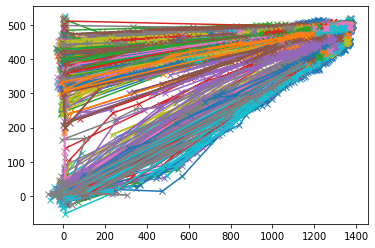

In [65]:
print(tracks)
print(ids)

for t in tracks:
  if t['v_id'] != 'Unspecified':
    plt.plot(t['x'],t['y'],'x-')

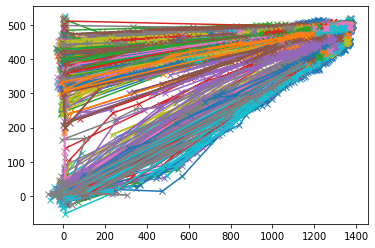

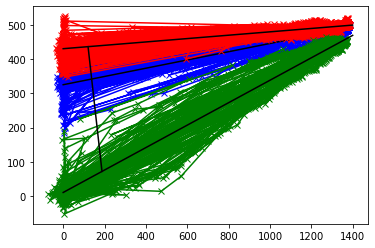

In [67]:
for t in tracks:
  if t['v_id'] != 'Unspecified':
    plt.plot(t['x'],t['y'],'x-')
plt.figure()
for c,color in zip(clusters,['b','r','g']):
  for t in c['tracks']:
    plt.plot(t['x'],t['y'],'x-',color=color)
  x_mean = list(range(0,1400))
  y_mean = c['mean'][0]*np.array(x_mean) + c['mean'][1]
  
  plt.plot(x_mean,y_mean,color='k')

plt.plot(final_points[:,0],final_points[:,1],'k')